In [1]:
import json
from collections import defaultdict
from pathlib import Path
from typing import Optional, Sequence

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

pd.set_option("display.max_colwidth", None)
import math
import shutil

from tqdm import tqdm

from common.constants import *
from common.helpers import get_train_meta

In [2]:
train_meta = get_train_meta(only_annotated=False)

In [3]:
annot = pd.read_parquet(next(Path("data/annotation").rglob("*.parquet")))
annot.head()

,agent_id,target_id,action,start_frame,stop_frame
0,1,2,shepherd,4856,4875
1,1,2,shepherd,5223,5411
2,2,1,shepherd,8860,8958
3,1,2,shepherd,15528,15618
4,1,2,shepherd,15693,15783


In [4]:
track = pd.read_parquet(next(Path("data/tracking").rglob("*.parquet")))
track.head()

,video_frame,mouse_id,bodypart,x,y
0,0,1,body_center,91.051407,248.028244
1,0,1,ear_left,101.369331,237.853195
2,0,1,ear_right,103.361198,244.359451
3,0,1,nose,109.108696,235.902039
4,0,1,tail_base,80.822174,249.293488


### Print names of all labs

In [5]:
all_lab_names = list(sorted(train_meta["lab_id"].unique()))
print(f"Cnt labs: {len(all_lab_names)}")
all_lab_names

Cnt labs: 21


['AdaptableSnail',
 'BoisterousParrot',
 'CRIM13',
 'CalMS21_supplemental',
 'CalMS21_task1',
 'CalMS21_task2',
 'CautiousGiraffe',
 'DeliriousFly',
 'ElegantMink',
 'GroovyShrew',
 'InvincibleJellyfish',
 'JovialSwallow',
 'LyricalHare',
 'MABe22_keypoints',
 'MABe22_movies',
 'NiftyGoldfinch',
 'PleasantMeerkat',
 'ReflectiveManatee',
 'SparklingTapir',
 'TranquilPanther',
 'UppityFerret']

### Duration (seconds) of active vs passive actions

In [6]:
from gbdt.rebalance_utils import DurationStats

# stats = DurationStats(actions=["tussle"])
stats = DurationStats(actions=ACTION_NAMES_IN_TEST)

df = pd.DataFrame(columns=["stat"], index=list(stats.duration_by_lab_id.keys()), data="")

for lab_id, duration_by_action in stats.duration_by_lab_id.items():
    sum_lab = 0.0
    for _, duration in duration_by_action.items():
        sum_lab += duration
    items = []
    for action, duration in duration_by_action.items():
        items.append((duration, f"{action}: {duration:.0f}s ({duration/sum_lab*100:.2f}%)"))
    items.sort(reverse=True)
    df.loc[lab_id, "stat"] = "<br>".join([desc for _, desc in items])
HTML(df.to_html(escape=False))

,stat
AdaptableSnail,passive: 385663s (98.38%)rear: 2844s (0.73%)attack: 1236s (0.32%)avoid: 910s (0.23%)chase: 614s (0.16%)submit: 283s (0.07%)approach: 269s (0.07%)chaseattack: 198s (0.05%)
BoisterousParrot,passive: 315832s (99.69%)shepherd: 982s (0.31%)
CRIM13,passive: 18500s (84.50%)sniff: 1209s (5.52%)selfgroom: 579s (2.64%)rear: 482s (2.20%)mount: 414s (1.89%)approach: 407s (1.86%)attack: 304s (1.39%)
CalMS21_supplemental,passive: 109511s (59.22%)sniff: 38227s (20.67%)sniffgenital: 17730s (9.59%)intromit: 7872s (4.26%)attack: 5973s (3.23%)mount: 2512s (1.36%)sniffbody: 1733s (0.94%)sniffface: 967s (0.52%)approach: 321s (0.17%)attemptmount: 88s (0.05%)
CalMS21_task1,passive: 19475s (62.18%)sniff: 4206s (13.43%)sniffgenital: 1830s (5.84%)mount: 1684s (5.38%)sniffbody: 1610s (5.14%)attack: 1161s (3.71%)sniffface: 751s (2.40%)intromit: 378s (1.21%)approach: 226s (0.72%)
CalMS21_task2,passive: 34053s (67.21%)sniff: 11074s (21.86%)mount: 3226s (6.37%)attack: 2311s (4.56%)
CautiousGiraffe,passive: 10296s (85.80%)reciprocalsniff: 932s (7.77%)sniffgenital: 212s (1.77%)escape: 208s (1.74%)sniff: 197s (1.64%)sniffbody: 120s (1.00%)chase: 34s (0.29%)
DeliriousFly,passive: 4224s (78.24%)dominance: 636s (11.78%)sniff: 412s (7.62%)attack: 127s (2.36%)
ElegantMink,passive: 25940s (82.72%)sniff: 2802s (8.94%)intromit: 1620s (5.17%)mount: 509s (1.62%)attack: 272s (0.87%)allogroom: 143s (0.46%)attemptmount: 72s (0.23%)
GroovyShrew,passive: 51877s (82.60%)rest: 2919s (4.65%)sniff: 2754s (4.38%)rear: 1692s (2.69%)dig: 1042s (1.66%)selfgroom: 763s (1.21%)approach: 633s (1.01%)sniffgenital: 504s (0.80%)climb: 288s (0.46%)escape: 208s (0.33%)run: 58s (0.09%)attemptmount: 38s (0.06%)defend: 31s (0.05%)


### Some per lab information

In [7]:
df = (
    train_meta.groupby("lab_id")["has_annotation"]
    .value_counts()
    .unstack(fill_value=0)
    .rename(columns={True: "With annotation", False: "No annotation"})
    .sort_values(by=["With annotation"], ascending=False)
)
df["Tracking methods"] = ""
for lab_id in all_lab_names:
    tracking_methods = train_meta[
        train_meta.lab_id == lab_id
    ].tracking_method.value_counts()
    t = ", ".join([f"{t} ({tracking_methods[t]})" for t in tracking_methods.index])
    df.loc[lab_id, "Tracking methods"] = t
all_bodyparts = set()
for video_meta in tqdm(train_meta.to_dict(orient="records")):
    cur = json.loads(video_meta["body_parts_tracked"])
    all_bodyparts = all_bodyparts.union(set(cur))
print(list(sorted(all_bodyparts)))
df["Bodyparts"] = ""
for lab_id in all_lab_names:
    bodyparts = train_meta[
        train_meta.lab_id == lab_id
    ].body_parts_tracked.value_counts()
    t = ", ".join([f"{t} ({bodyparts[t]})" for t in bodyparts.index])
    df.loc[lab_id, "Bodyparts"] = t
df["Total frames"] = ""
actions_col = "Actions (cnt segments)"
df[actions_col] = ""
df["Cnt actions"] = 0
total_frames = 0
total_frames_with_annotation = 0
for lab_id in all_lab_names:
    cnt_by_action = defaultdict(int)
    total_frames_this_lab = 0
    video_ids_with_annotation = set()
    for video_id in train_meta[
        (train_meta.lab_id == lab_id) & train_meta.has_annotation == True
    ].video_id:
        annot = pd.read_parquet(
            Path("data") / "annotation" / lab_id / f"{video_id}.parquet"
        )
        actions = annot.action.value_counts()
        for action in actions.index:
            cnt_by_action[action] += actions[action]
        video_ids_with_annotation.add(video_id)
    for video_id in tqdm(
        train_meta[train_meta.lab_id == lab_id].video_id, disable=True
    ):
        track = pd.read_parquet(
            Path("data") / "tracking" / lab_id / f"{video_id}.parquet"
        )
        cnt_frames = int(track["video_frame"].max()) + 1
        total_frames_this_lab += cnt_frames
        total_frames += cnt_frames
        if video_id in video_ids_with_annotation:
            total_frames_with_annotation += cnt_frames
    actions = [(v, k) for k, v in cnt_by_action.items()]
    actions.sort(reverse=True)
    df.loc[lab_id, "Cnt actions"] = len(actions)
    actions = ", ".join(
        f"{action[1]} ({cnt_by_action[action[1]]})" for action in actions
    )
    df.loc[lab_id, actions_col] = actions
    df.loc[lab_id, "Total frames"] = f"{total_frames_this_lab/10**6:.2f}M"
    total_frames += total_frames_this_lab
print(f"Total frames                 : {total_frames/10**6:.2f}M")
print(f"Total frames with annotation : {total_frames_with_annotation/10**6:.2f}M")
print(f"Total videos with annotation : {df["With annotation"].sum()}")
print(f"Total videos no annotation   : {df["No annotation"].sum()}")
print(f"Total videos                 : {len(train_meta)}")
df

100%|██████████| 8789/8789 [00:00<00:00, 675419.81it/s]


['body_center', 'ear_left', 'ear_right', 'forepaw_left', 'forepaw_right', 'head', 'headpiece_bottombackleft', 'headpiece_bottombackright', 'headpiece_bottomfrontleft', 'headpiece_bottomfrontright', 'headpiece_topbackleft', 'headpiece_topbackright', 'headpiece_topfrontleft', 'headpiece_topfrontright', 'hindpaw_left', 'hindpaw_right', 'hip_left', 'hip_right', 'lateral_left', 'lateral_right', 'neck', 'nose', 'spine_1', 'spine_2', 'tail_base', 'tail_middle_1', 'tail_middle_2', 'tail_midpoint', 'tail_tip']
Total frames                 : 71.85M
Total frames with annotation : 21.57M
Total videos with annotation : 848
Total videos no annotation   : 7941
Total videos                 : 8789


has_annotation,No annotation,With annotation,Tracking methods,Bodyparts,Total frames,Actions (cnt segments),Cnt actions
lab_id,,,,,,,
CalMS21_supplemental,0,297,MARS (297),"[""ear_left"", ""ear_right"", ""hip_left"", ""hip_right"", ""neck"", ""nose"", ""tail_base""] (297)",5.55M,"sniff (18511), sniffgenital (4457), attack (2540), sniffbody (1885), mount (1082), sniffface (949), approach (510), intromit (422), dominancemount (410), attemptmount (102)",10
CalMS21_task1,0,101,MARS (101),"[""ear_left"", ""ear_right"", ""hip_left"", ""hip_right"", ""neck"", ""nose"", ""tail_base""] (101)",0.94M,"sniff (2736), sniffbody (1524), sniffgenital (1020), sniffface (639), attack (557), mount (481), approach (349), genitalgroom (50), intromit (37)",9
CalMS21_task2,0,76,MARS (76),"[""ear_left"", ""ear_right"", ""hip_left"", ""hip_right"", ""neck"", ""nose"", ""tail_base""] (76)",1.52M,"sniff (4669), attack (1173), mount (494)",3
SparklingTapir,15,54,DeepLabCut (69),"[""body_center"", ""ear_left"", ""ear_right"", ""lateral_left"", ""lateral_right"", ""nose"", ""tail_base""] (69)",0.72M,"attack (502), defend (315), escape (265), mount (89)",4
JovialSwallow,0,52,SLEAP (52),"[""ear_left"", ""ear_right"", ""hip_left"", ""hip_right"", ""neck"", ""nose"", ""tail_base""] (52)",0.47M,"sniff (2939), attack (178), chase (63)",3
PleasantMeerkat,0,36,DeepLabCut (36),"[""body_center"", ""ear_left"", ""ear_right"", ""lateral_left"", ""lateral_right"", ""nose"", ""tail_base"", ""tail_tip""] (36)",0.97M,"attack (437), escape (226), chase (197), follow (58)",4
InvincibleJellyfish,0,33,MARS (33),"[""ear_left"", ""ear_right"", ""hip_left"", ""hip_right"", ""neck"", ""nose"", ""tail_base""] (33)",0.73M,"sniff (1147), sniffgenital (482), attack (265), escape (72), dig (72), dominancegroom (53), selfgroom (27), allogroom (19)",8
TranquilPanther,0,25,SLEAP (25),"[""ear_left"", ""ear_right"", ""hip_left"", ""hip_right"", ""neck"", ""nose"", ""tail_base""] (25)",1.25M,"sniff (1070), rear (453), sniffgenital (330), mount (296), selfgroom (141), intromit (89)",6
LyricalHare,0,24,DeepLabCut (24),"[""ear_left"", ""ear_right"", ""nose"", ""tail_base"", ""tail_tip""] (24)",0.89M,"defend (473), escape (399), attack (208), rear (118), sniff (106), freeze (105), approach (46)",7


### Video length histogram per lab

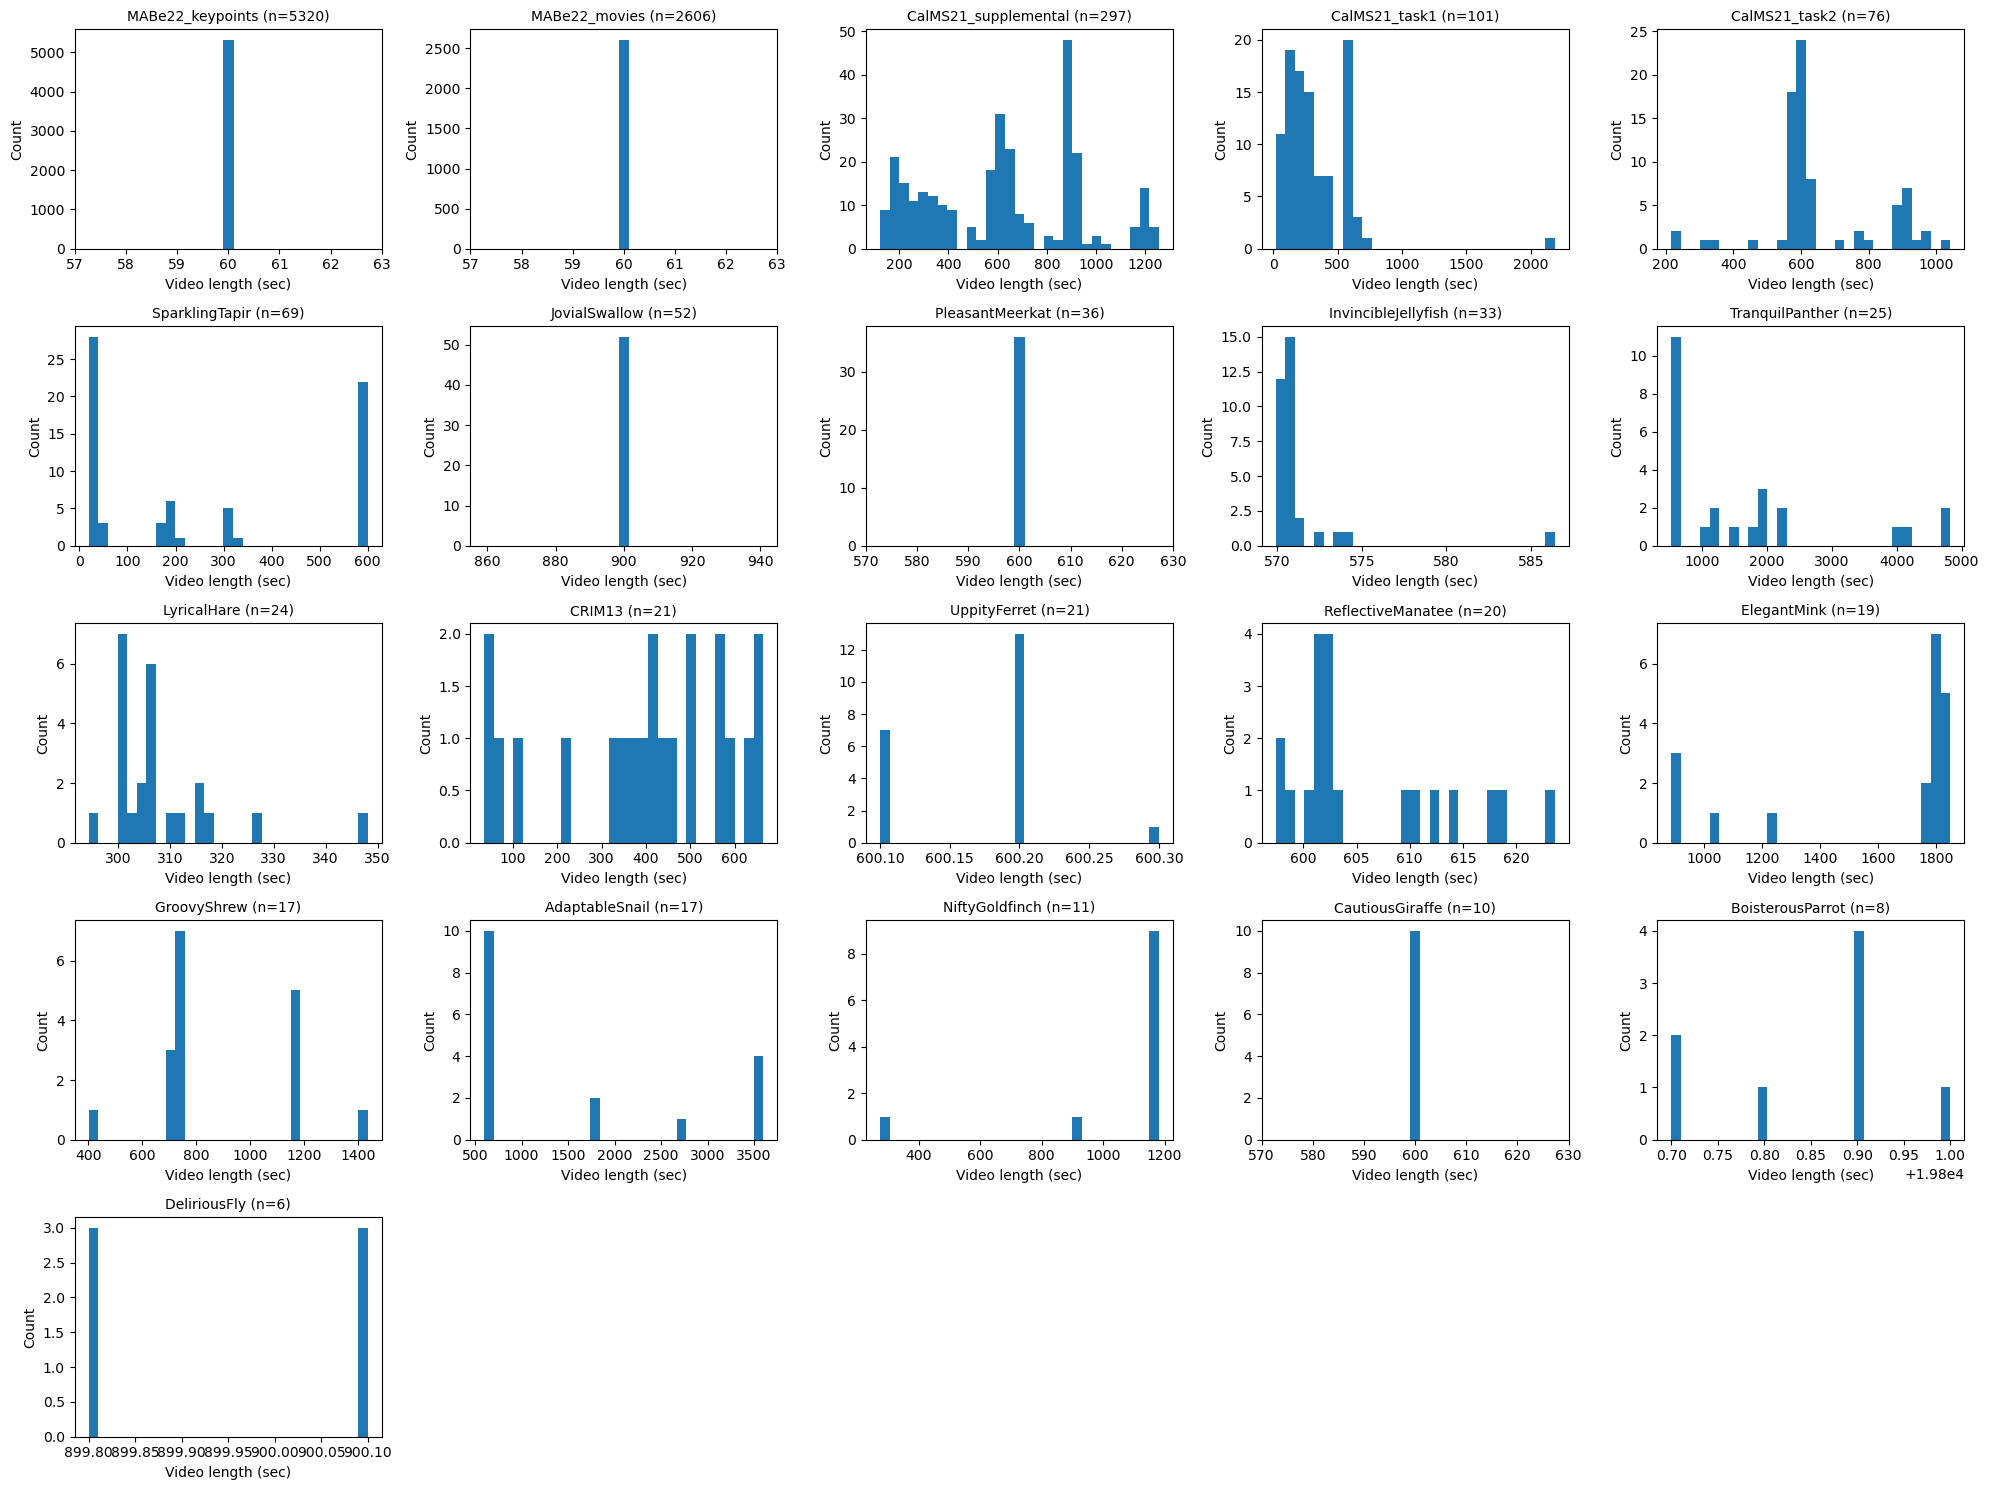

In [8]:
df = train_meta.dropna(subset=['lab_id', 'video_duration_sec']).copy()

# Sort labs by number of videos
lab_counts = df.groupby('lab_id').size().sort_values(ascending=False)
labs = lab_counts.index.tolist()

# Grid layout
n = len(labs)
ncols = int(math.ceil(math.sqrt(n)))
nrows = int(math.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False)
axes = axes.ravel()

for ax, lab in zip(axes, labs):
    lengths = df.loc[df['lab_id'] == lab, 'video_duration_sec'].values
    if lengths.size == 0:
        ax.axis('off')
        continue

    xmin, xmax = float(np.min(lengths)), float(np.max(lengths))
    if xmax > xmin:
        bins = np.linspace(xmin, xmax, 30)
        pad = 0.05 * (xmax - xmin)
        ax.set_xlim(xmin - pad, xmax + pad)
    else:
        pad = max(1e-6, 0.05 * (abs(xmin) if xmin != 0 else 1.0))
        bins = np.linspace(xmin - pad, xmax + pad, 30)
        ax.set_xlim(xmin - pad, xmax + pad)

    ax.hist(lengths, bins=bins)
    ax.set_title(f"{lab} (n={len(lengths)})", fontsize=10)
    ax.set_xlabel("Video length (sec)")
    ax.set_ylabel("Count")

# Hide any unused axes
for ax in axes[len(labs):]:
    ax.axis('off')

fig.tight_layout()
plt.show()

### Cnt frames per video histogram (labs in test)

Total videos: 353


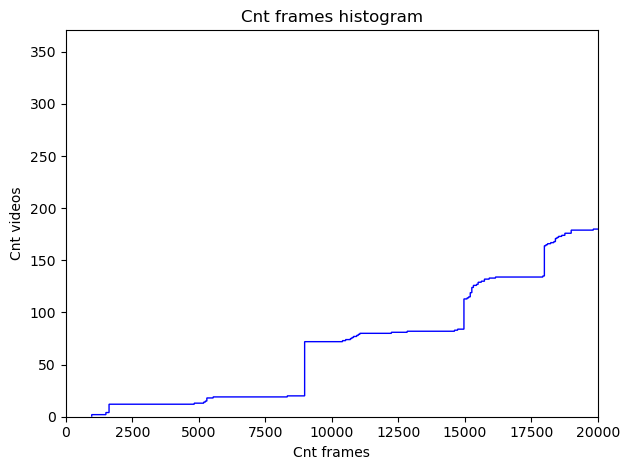

In [40]:
meta = train_meta[train_meta.has_annotation]
lengths = []
for video_meta in meta.to_dict(orient="records"):
    if video_meta["lab_id"] not in LAB_NAMES_IN_TEST:
        continue
    c = video_meta["cnt_frames"]
    lengths.append(c)

print(f"Total videos: {len(lengths)}")
plt.figure()
plt.hist(lengths, bins=10000, edgecolor="blue", cumulative=True, histtype="step")
plt.xlim(0, 20000)
plt.title("Cnt frames histogram")
plt.xlabel("Cnt frames")
plt.ylabel("Cnt videos")
plt.tight_layout()
plt.show()

### Number of distinct labelled actions per video per lab

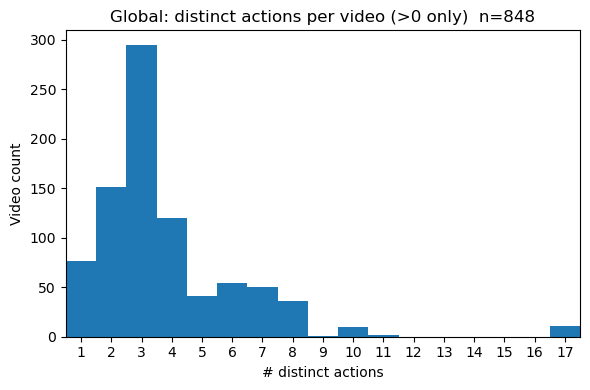

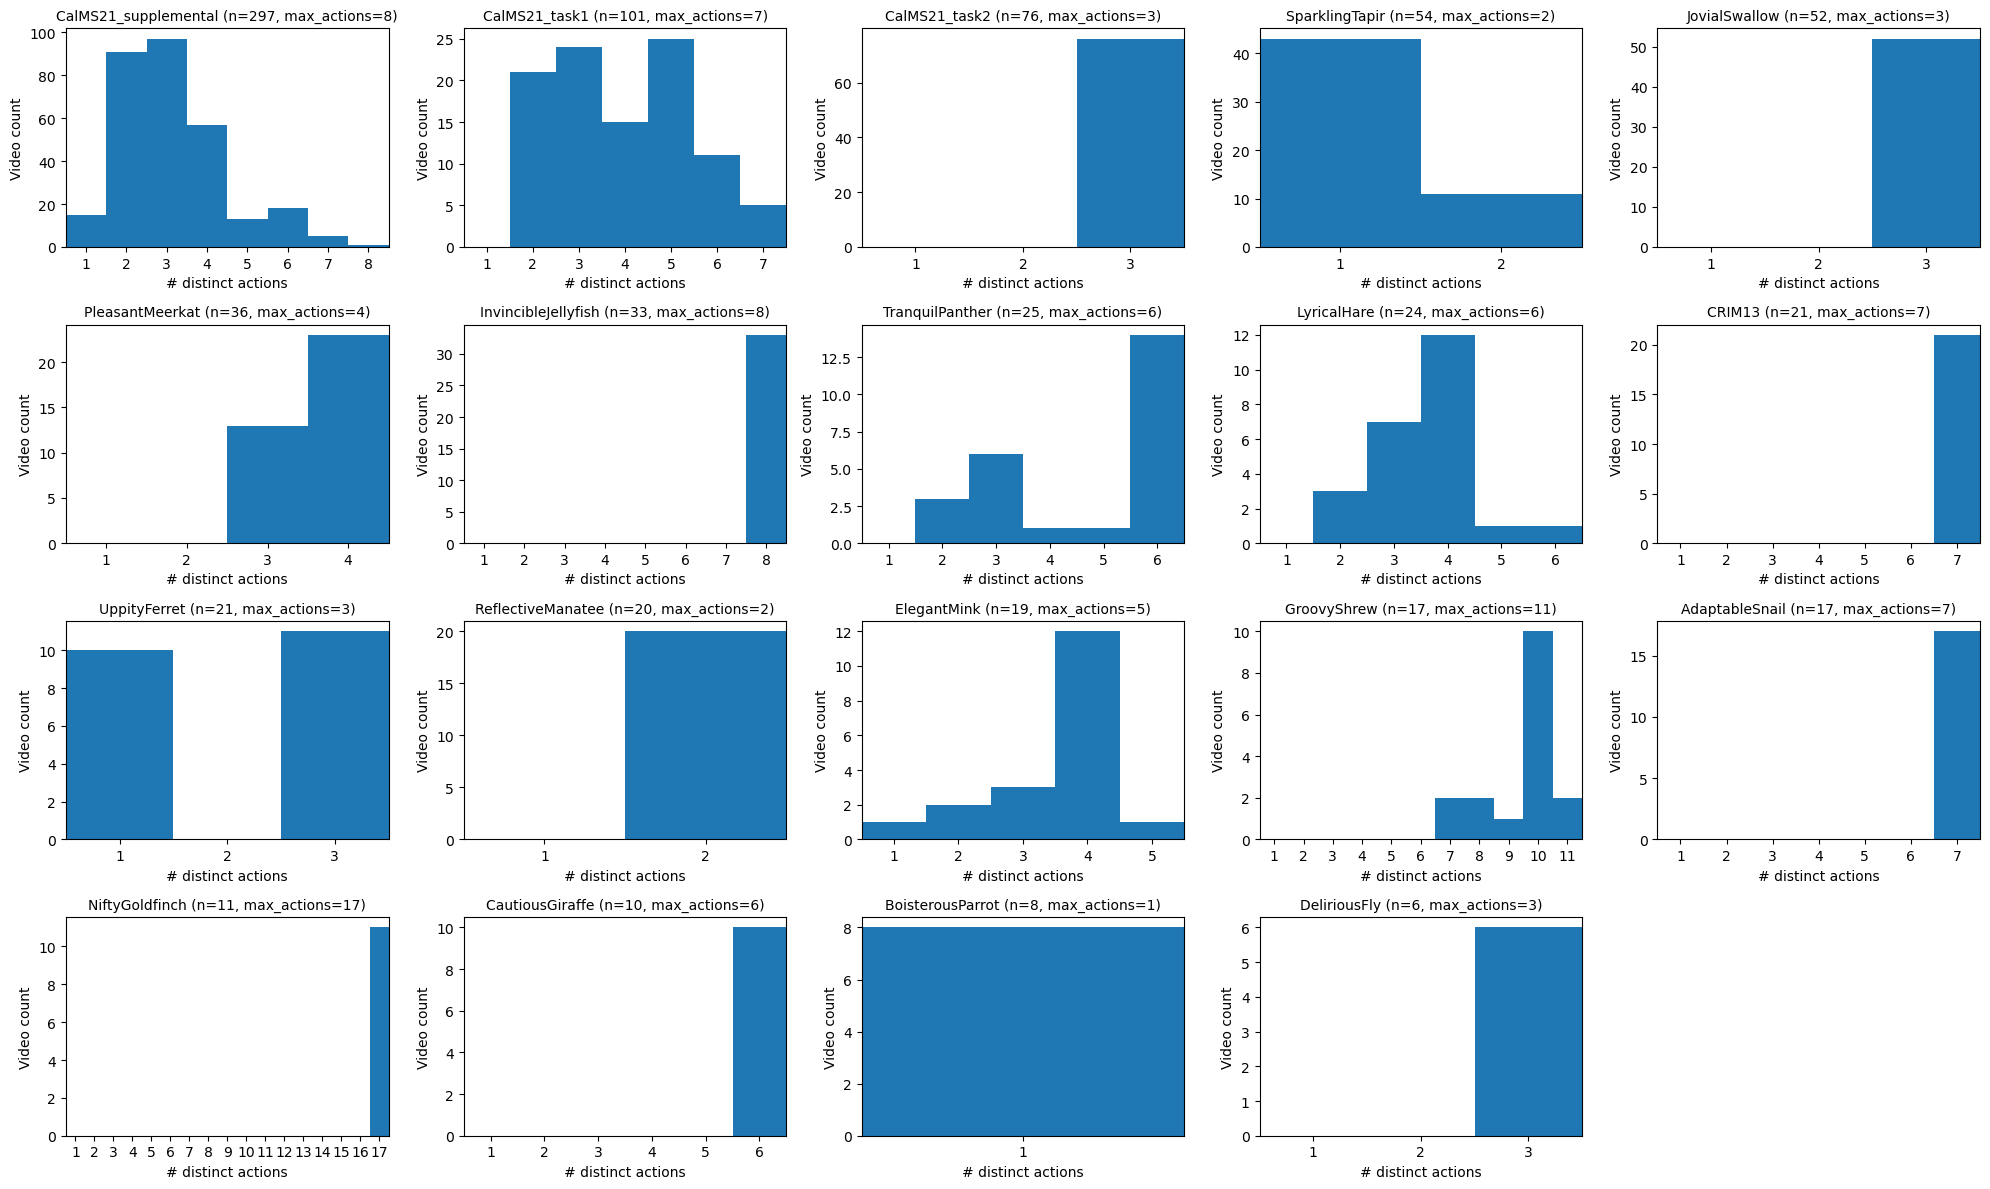

In [41]:
def cnt_actions(val):
    if pd.isna(val):
        return 0
    val = json.loads(val)
    s = set(item.split(",")[2] for item in val)
    return len(s)

# Compute a_video for each row
meta = train_meta[['lab_id','video_id','behaviors_labeled']].copy()
meta['a_video'] = meta['behaviors_labeled'].apply(cnt_actions).astype(int)

# Keep only videos with >0 actions
meta_pos = meta[meta['a_video'] > 0].copy()
if meta_pos.empty:
    print("No videos with >0 actions. Nothing to plot.")
else:
    # --- Global histogram (integer x-axis 1..gmax) ---
    vals = meta_pos['a_video'].values
    gmin, gmax = int(vals.min()), int(vals.max())
    gbins = np.arange(0.5, gmax + 1.5, 1.0)  # centers at integers

    plt.figure(figsize=(6, 4))
    plt.hist(vals, bins=gbins)
    plt.title(f"Global: distinct actions per video (>0 only)  n={len(vals)}")
    plt.xlabel("# distinct actions")
    plt.ylabel("Video count")
    plt.xticks(range(1, gmax + 1))
    plt.xlim(0.5, gmax + 0.5)
    plt.tight_layout()
    plt.show()

    # --- Per-lab histograms (x-axis integers 1..b_lab), labs sorted by filtered count desc ---
    lab_counts = meta_pos.groupby('lab_id').size().sort_values(ascending=False)
    labs = lab_counts.index.tolist()

    n = len(labs)
    ncols = int(math.ceil(math.sqrt(n))) if n else 1
    nrows = int(math.ceil(n / ncols)) if n else 1

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False)
    axes = axes.ravel()

    for ax, lab in zip(axes, labs):
        lv = meta_pos.loc[meta_pos['lab_id'] == lab, 'a_video'].values
        if lv.size == 0:
            ax.axis('off'); continue

        max_actions = int(lv.max())
        bins_lab = np.arange(0.5, max_actions + 1.5, 1.0)

        ax.hist(lv, bins=bins_lab)
        ax.set_title(f"{lab} (n={len(lv)}, max_actions={max_actions})", fontsize=10)
        ax.set_xlabel("# distinct actions")
        ax.set_ylabel("Video count")
        ax.set_xticks(range(1, max_actions + 1))
        ax.set_xlim(0.5, max_actions + 0.5)

    for ax in axes[len(labs):]:
        ax.axis('off')

    fig.tight_layout()
    plt.show()


### Some per-action information

In [42]:
from common.helpers import get_annotation_by_video_meta


cnt_videos_per_action = defaultdict(int)
total_duration_per_action = defaultdict(float)
cnt_active_frames_per_action = defaultdict(float)
cnt_passive_frames_per_action = defaultdict(float)
cnt_segments_per_action = defaultdict(int)
labs_per_action = defaultdict(set)
type_per_action = {}
for row in tqdm(
    train_meta[train_meta.has_annotation].to_dict(orient="records"),
    desc="Videos with annotation",
):
    annot = get_annotation_by_video_meta(row)
    for action in annot.action.unique():
        cnt_videos_per_action[str(action)] += 1
    fps = int(row["frames_per_second"])
    # cnt_frames_video = int(row["video_duration_sec"] * fps)
    cnt_frames_video = int(row["cnt_frames"])
    cnt_active_frames_counter = defaultdict(int)
    for row_action in annot.to_dict(orient="records"):
        action = row_action["action"]
        agent = row_action["agent_id"]
        target = row_action["target_id"]
        cnt_frames = row_action["stop_frame"] - row_action["start_frame"]
        cnt_active_frames_per_action[action] += cnt_frames
        cnt_active_frames_counter[(agent, target, action)] += cnt_frames
        duration = cnt_frames / fps
        total_duration_per_action[action] += duration
        labs_per_action[action].add(row["lab_id"])
        if agent == target:
            assert action not in type_per_action or type_per_action[action] == "self"
            type_per_action[action] = "self"
        else:
            assert action not in type_per_action or type_per_action[action] == "pair"
            type_per_action[action] = "pair"
        cnt_segments_per_action[action] += 1
    for (agent, target, action), cnt_active in cnt_active_frames_counter.items():
        cnt_passive_frames_per_action[action] += cnt_frames_video - cnt_active

df = pd.DataFrame(
    index=list(cnt_videos_per_action.keys()),
    columns=[
        "Cnt videos",
        "Type",
        "Total duration (s)",
        "Cnt labs",
        "Cnt segments",
        "Cnt active frames",
        "Cnt passive frames",
    ],
    data=0,
)
df = df.astype({"Type": "str"})

total_frames = 0
for _, v in cnt_active_frames_per_action.items():
    total_frames += v
print(f"Total frames (annotated): {total_frames/10**6:.2f}M")

for k, v in cnt_videos_per_action.items():
    df.loc[k, "Cnt videos"] = v
for k, v in total_duration_per_action.items():
    df.loc[k, "Total duration (s)"] = int(v)
for k, v in labs_per_action.items():
    df.loc[k, "Cnt labs"] = len(v)
for k, v in type_per_action.items():
    df.loc[k, "Type"] = v
for k, v in cnt_segments_per_action.items():
    df.loc[k, "Cnt segments"] = v
for k, v in cnt_active_frames_per_action.items():
    df.loc[k, "Cnt active frames"] = f"{v/10**6:.4f} M"
for k, v in cnt_passive_frames_per_action.items():
    df.loc[k, "Cnt passive frames"] = f"{v/10**6:.4f} M"

all_self_actions = []
all_pair_actions = []
for k, v in type_per_action.items():
    match v:
        case "pair":
            all_pair_actions.append(k)
        case "self":
            all_self_actions.append(k)
        case _:
            raise ValueError()

all_pair_actions.sort()
all_self_actions.sort()

print(f"ALL_PAIR_ACTIONS = {all_pair_actions}")
print(f"ALL_SELF_ACTIONS = {all_self_actions}")

df = df.sort_values(by=["Cnt videos"], ascending=False)
print(list(sorted(df.index)))
df

Videos with annotation: 100%|██████████| 848/848 [00:00<00:00, 935.72it/s]

Total frames (annotated): 5.33M
ALL_PAIR_ACTIONS = ['allogroom', 'approach', 'attack', 'attemptmount', 'avoid', 'chase', 'chaseattack', 'defend', 'disengage', 'dominance', 'dominancegroom', 'dominancemount', 'escape', 'flinch', 'follow', 'intromit', 'mount', 'reciprocalsniff', 'shepherd', 'sniff', 'sniffbody', 'sniffface', 'sniffgenital', 'submit', 'tussle']
ALL_SELF_ACTIONS = ['biteobject', 'climb', 'dig', 'exploreobject', 'freeze', 'genitalgroom', 'huddle', 'rear', 'rest', 'run', 'selfgroom']
['allogroom', 'approach', 'attack', 'attemptmount', 'avoid', 'biteobject', 'chase', 'chaseattack', 'climb', 'defend', 'dig', 'disengage', 'dominance', 'dominancegroom', 'dominancemount', 'escape', 'exploreobject', 'flinch', 'follow', 'freeze', 'genitalgroom', 'huddle', 'intromit', 'mount', 'rear', 'reciprocalsniff', 'rest', 'run', 'selfgroom', 'shepherd', 'sniff', 'sniffbody', 'sniffface', 'sniffgenital', 'submit', 'tussle']



/tmp/ipykernel_3530276/495412599.py:73: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.2309 M' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[k, "Cnt active frames"] = f"{v/10**6:.4f} M"
/tmp/ipykernel_3530276/495412599.py:75: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.7196 M' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[k, "Cnt passive frames"] = f"{v/10**6:.4f} M"


,Cnt videos,Type,Total duration (s),Cnt labs,Cnt segments,Cnt active frames,Cnt passive frames
sniff,594,pair,77159,14,37837,2.1506 M,11.4606 M
sniffgenital,405,pair,23820,8,7862,0.7039 M,8.1677 M
attack,332,pair,15739,14,7462,0.5189 M,8.7316 M
mount,247,pair,9566,7,2747,0.2849 M,5.1103 M
approach,159,pair,2732,7,3270,0.0860 M,4.2737 M
sniffbody,109,pair,3462,3,3518,0.1033 M,0.7707 M
sniffface,108,pair,2384,3,2811,0.0715 M,1.3864 M
escape,93,pair,1989,7,2071,0.0903 M,3.3095 M
rear,85,self,7302,6,4408,0.2309 M,3.7196 M
selfgroom,81,self,2821,5,1356,0.0818 M,3.2259 M


### Per-action duration histograms

In [ ]:
annotations = []
for annot_path in (Path("data") / "annotation").rglob("*.parquet"):
    annot = pd.read_parquet(annot_path)
    video_id = annot_path.name.replace(".parquet", "")
    annot["video_id"] = int(video_id)
    annotations.append(annot)
annotations = pd.concat(annotations)

# Merge FPS into annotations and compute segment lengths in seconds
ann = annotations.merge(train_meta[['video_id','frames_per_second']], on='video_id', how='left')
ann = ann.dropna(subset=['frames_per_second']).copy()
ann['length_sec'] = (ann['stop_frame'] - ann['start_frame']) / ann['frames_per_second']

# Sort actions by number of segments
action_counts = ann.groupby('action').size().sort_values(ascending=False)
actions = action_counts.index.tolist()

# Grid of histograms
n = len(actions)
ncols = int(math.ceil(math.sqrt(n)))
nrows = int(math.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False)
axes = axes.ravel()

for ax, action in zip(axes, actions):
    lengths = ann.loc[ann['action'] == action, 'length_sec'].values
    if lengths.size == 0:
        ax.axis('off')
        continue

    # xmin, xmax = float(np.min(lengths)), float(np.max(lengths))
    xmin, xmax = float(np.percentile(lengths, 1)), float(np.percentile(lengths, 99))

    if xmax > xmin:
        # bins span exactly this action's range
        bins = np.linspace(xmin, xmax, 30)
        pad = 0.05 * (xmax - xmin)
        ax.set_xlim(xmin - pad, xmax + pad)
    else:
        # all segments same length; give a small symmetric window
        pad = max(1e-6, 0.05 * (abs(xmin) if xmin != 0 else 1.0))
        bins = np.linspace(xmin - pad, xmax + pad, 30)
        ax.set_xlim(xmin - pad, xmax + pad)

    ax.hist(lengths, bins=bins)
    ax.set_title(f"{action} (n={len(lengths)})", fontsize=10)
    ax.set_xlabel("Segment length (sec)")
    ax.set_ylabel("Count")

# Hide any unused axes
for ax in axes[len(actions):]:
    ax.axis('off')

fig.tight_layout()
plt.show()


### FPS histogram per lab

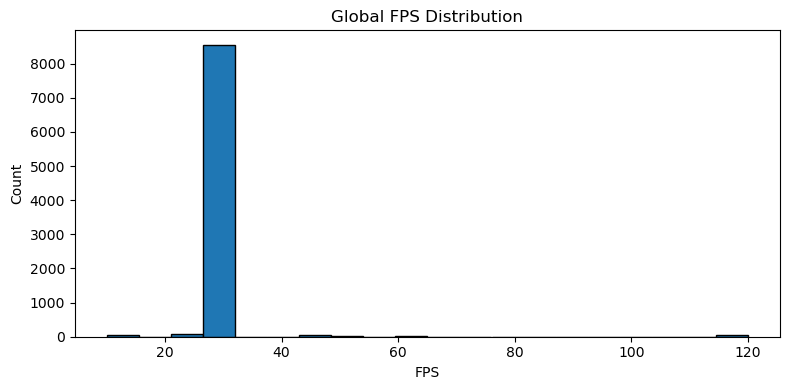

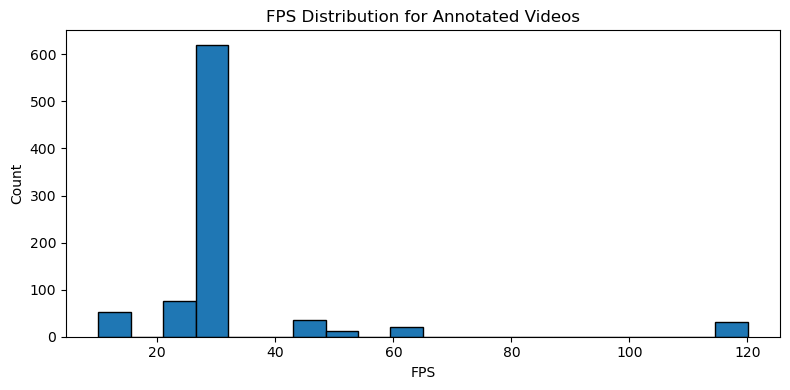

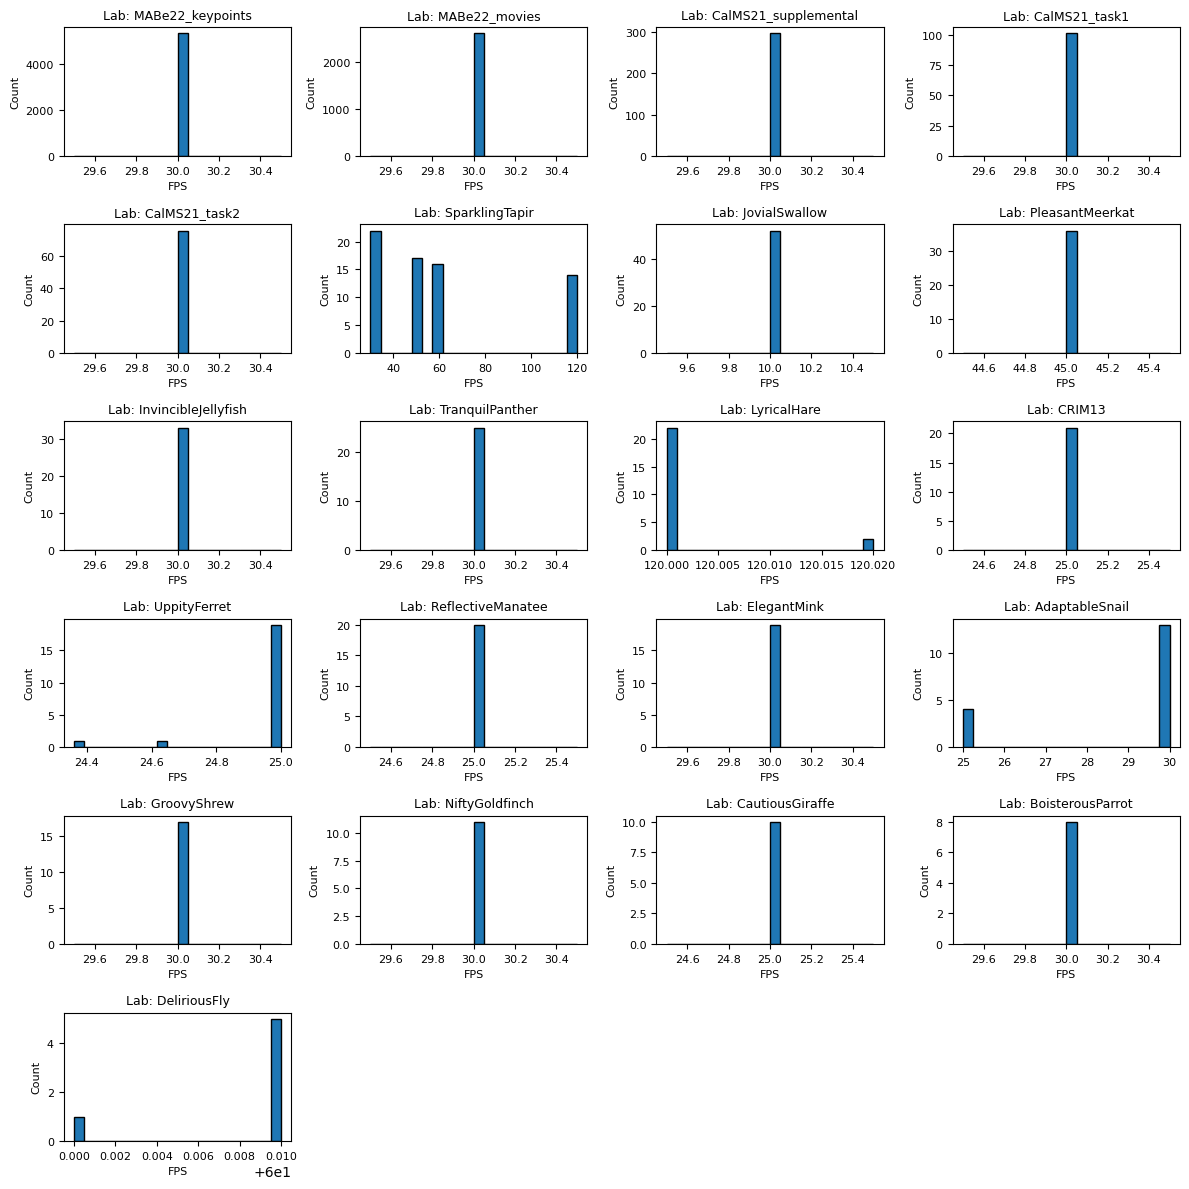

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# Assume train_meta is your DataFrame
# Columns: 'lab_id' (str), 'frames_per_second' (int)

# Get unique labs
labs = train_meta['lab_id'].unique()
labs = list(sorted(labs, key=lambda lab: sum(train_meta.lab_id == lab), reverse=True))

plt.figure(figsize=(8, 4))
plt.hist(train_meta['frames_per_second'], bins=20, edgecolor='black')
plt.title("Global FPS Distribution")
plt.xlabel("FPS")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(train_meta[train_meta.has_annotation]['frames_per_second'], bins=20, edgecolor='black')
plt.title("FPS Distribution for Annotated Videos")
plt.xlabel("FPS")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# --- Per-lab histograms ---
n_labs = len(labs)
n_cols = 4  # more columns to fit more on one screen
n_rows = (n_labs + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 2 * n_rows))
axes = axes.flatten()

for i, lab in enumerate(labs):
    ax = axes[i]
    fps_values = train_meta.loc[train_meta['lab_id'] == lab, 'frames_per_second']
    ax.hist(fps_values, bins=20, edgecolor='black')
    ax.set_title(f"Lab: {lab}", fontsize=9)
    ax.set_xlabel("FPS", fontsize=8)
    ax.set_ylabel("Count", fontsize=8)
    ax.tick_params(axis='both', labelsize=8)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()


### Some per-tracked-keypoint information

In [ ]:
all_keypoints = set()
for s in train_meta["body_parts_tracked"]:
    s = json.loads(s)
    s = set(s)
    all_keypoints |= s

df = pd.DataFrame(
    index=list(all_keypoints),
    columns=[
        "Annotated videos",
        "Not annotated videos",
        "Total videos",
        "Labs",
        "Tracking methods",
    ],
    data=0,
)
df = df.astype({"Labs": "str", "Tracking methods": "str"})

for k in all_keypoints:
    cur_train_meta = train_meta[train_meta[f"tracked_{k}"]]
    df.loc[k, "Annotated videos"] = sum(
        cur_train_meta.has_annotation
    )
    df.loc[k, "Not annotated videos"] = sum(
        ~cur_train_meta.has_annotation 
    )
    labs = list(cur_train_meta.lab_id.unique())
    labs_str = str(len(labs))
    if len(labs) == 1:
        labs_str += f" ({labs[0]})"
    df.loc[k, "Labs"] = labs_str
    tracking_methods = list(
        cur_train_meta.tracking_method.unique()
    )
    cnt_per_tracking_method = {}
    for t in tracking_methods:
        cnt_per_tracking_method[t] = sum(cur_train_meta.tracking_method == t)
    tracking_methods = [f"{t} ({cnt_per_tracking_method[t]})" for t in tracking_methods]
    tracking_methods = ", ".join(tracking_methods)
    df.loc[k, "Tracking methods"] = tracking_methods
df["Total videos"] = df["Annotated videos"] + df["Not annotated videos"]
df = df.sort_values(by=["Annotated videos"], ascending=False)
df

### Missing tracking per keypoint (annotated videos only)

In [ ]:
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import hashlib, json, os, pickle


def compute_keypoint_coverage(
    train_meta: pd.DataFrame,
    data_root="data",
    annot_subdir="annotation",
    tracking_subdir="tracking",
    max_videos: int | None = None,
    # caching
    cache_dir: str | Path | None = None,
    force_recompute: bool = False,
) -> pd.DataFrame:
    """
    Build a dataframe with:
      keypoint_name, frames_missing, frames_tracked, frames_missing_in_action, frames_tracked_in_action,
      missing_p, missing_p_in_action

    Caching:
      - If cache_dir is provided, a cache key is built from:
          * data_root, annot_subdir, tracking_subdir
          * max_videos
          * list of eligible videos (lab_id, video_id)
          * per-video annotation & tracking file mtimes
          * per-video tracked_* flags (which determine considered keypoints)
      - Set force_recompute=True to ignore cache and recompute.
    """
    data_root = Path(data_root)

    # --------- helpers ---------
    def tracked_keypoints_from_meta(meta_row: pd.Series) -> list[str]:
        return [
            c.replace("tracked_", "")
            for c, v in meta_row.items()
            if isinstance(c, str) and c.startswith("tracked_") and isinstance(v, (bool, np.bool_)) and v
        ]

    def merge_intervals(intervals: list[tuple[int, int]]) -> list[tuple[int, int]]:
        if not intervals:
            return []
        intervals = sorted(intervals, key=lambda z: (z[0], z[1]))
        merged = []
        s, e = intervals[0]
        for ns, ne in intervals[1:]:
            if ns <= e:
                e = max(e, ne)
            else:
                merged.append((s, e))
                s, e = ns, ne
        merged.append((s, e))
        return merged

    def build_mouse_intervals(annot_df: pd.DataFrame) -> dict[int, list[tuple[int, int]]]:
        d = defaultdict(list)
        if annot_df.empty:
            return {}
        for _, r in annot_df.iterrows():
            a = int(r["agent_id"])
            t = int(r["target_id"])
            s = int(r["start_frame"])
            e = int(r["stop_frame"])
            if s >= e:
                continue
            d[a].append((s, e))
            d[t].append((s, e))
        return {m: merge_intervals(iv) for m, iv in d.items()}

    def mark_in_action_for_pairs(
        pairs_df: pd.DataFrame, intervals_by_mouse: dict[int, list[tuple[int, int]]]
    ) -> np.ndarray:
        if pairs_df.empty:
            return np.zeros(0, dtype=bool)
        arr_mouse = pairs_df["mouse_id"].to_numpy()
        arr_frame = pairs_df["video_frame"].to_numpy()
        mask = np.zeros(len(pairs_df), dtype=bool)
        uniq_m, starts, counts = np.unique(arr_mouse, return_index=True, return_counts=True)
        for m, s, c in zip(uniq_m, starts, counts):
            frames = arr_frame[s : s + c]
            ivals = intervals_by_mouse.get(int(m), [])
            if not ivals:
                continue
            for iv_s, iv_e in ivals:  # half-open [start, stop)
                l = np.searchsorted(frames, iv_s, side="left")
                r = np.searchsorted(frames, iv_e, side="left")
                if l < r:
                    mask[s + l : s + r] = True
        return mask

    # --------- select videos ---------
    annotated = train_meta[train_meta["has_annotation"] == True]
    if max_videos is not None:
        annotated = annotated.iloc[:max_videos]

    # --------- cache key ---------
    cache_path = None
    if cache_dir is not None:
        cache_dir = Path(cache_dir)
        cache_dir.mkdir(parents=True, exist_ok=True)

        # include per-video file mtimes + tracked_* flags
        videos_sig = []
        for _, r in annotated.iterrows():
            lab_id = r["lab_id"]; video_id = r["video_id"]
            annot_path = data_root / annot_subdir / str(lab_id) / f"{video_id}.parquet"
            track_path = data_root / tracking_subdir / str(lab_id) / f"{video_id}.parquet"
            annot_mtime = os.path.getmtime(annot_path) if annot_path.exists() else None
            track_mtime = os.path.getmtime(track_path) if track_path.exists() else None
            videos_sig.append({
                "lab_id": str(lab_id),
                "video_id": str(video_id),
                "annot_path": str(annot_path),
                "track_path": str(track_path),
                "annot_mtime": None if annot_mtime is None else round(float(annot_mtime), 3),
                "track_mtime": None if track_mtime is None else round(float(track_mtime), 3),
                "tracked_kps": sorted(tracked_keypoints_from_meta(r)),
            })

        key_obj = {
            "fn": "compute_keypoint_coverage_v1",
            "data_root": str(data_root.resolve()),
            "annot_subdir": str(annot_subdir),
            "tracking_subdir": str(tracking_subdir),
            "max_videos": None if max_videos is None else int(max_videos),
            "videos": videos_sig,
        }
        key_str = json.dumps(key_obj, sort_keys=True)
        key_hash = hashlib.sha256(key_str.encode("utf-8")).hexdigest()[:16]
        cache_path = cache_dir / f"kp_coverage_{key_hash}.pkl"

    # return cached df if available
    if cache_path is not None and cache_path.exists() and not force_recompute:
        with open(cache_path, "rb") as f:
            cached = pickle.load(f)
        # return as-is (already sorted & with percentage strings)
        return cached

    # --------- compute ---------
    agg = defaultdict(
        lambda: {
            "frames_missing": 0,
            "frames_tracked": 0,
            "frames_missing_in_action": 0,
            "frames_tracked_in_action": 0,
        }
    )

    for _, row in tqdm(annotated.iterrows(), total=len(annotated), desc="Videos"):
        lab_id = row["lab_id"]
        video_id = row["video_id"]

        # Keypoints tracked in this video
        kps = tracked_keypoints_from_meta(row)
        assert kps

        # Annotation
        annot_path = data_root / annot_subdir / str(lab_id) / f"{video_id}.parquet"
        assert annot_path.exists()
        annot = pd.read_parquet(
            annot_path, columns=["agent_id", "target_id", "start_frame", "stop_frame"]
        )
        intervals_by_mouse = build_mouse_intervals(annot)

        # Tracking (minimal columns)
        track_path = data_root / tracking_subdir / str(lab_id) / f"{video_id}.parquet"
        assert track_path.exists()
        track = pd.read_parquet(
            track_path, columns=["video_frame", "mouse_id", "bodypart"]
        )
        if track.empty:
            continue

        # NOTE: we intentionally DO NOT filter by kps here,
        # so denominator is "all (frame,mouse) pairs present in the tracking file".
        track["mouse_id"] = track["mouse_id"].astype(np.int16, copy=False)
        track["video_frame"] = track["video_frame"].astype(np.int32, copy=False)
        track["bodypart"] = track["bodypart"].astype("category")

        # Universe of (frame, mouse) pairs
        pairs = (
            track[["video_frame", "mouse_id"]]
            .drop_duplicates()
            .sort_values(["mouse_id", "video_frame"], kind="mergesort")
            .reset_index(drop=True)
        )
        total_pairs = len(pairs)
        in_action_mask = mark_in_action_for_pairs(pairs, intervals_by_mouse)
        total_pairs_in_action = int(in_action_mask.sum())

        # Unique rows per keypoint
        track_unique = track.drop_duplicates(["video_frame", "mouse_id", "bodypart"])

        # Attach in_action flag
        pairs_with_flag = pairs.copy()
        pairs_with_flag["in_action"] = in_action_mask
        tu = track_unique.merge(
            pairs_with_flag,
            on=["video_frame", "mouse_id"],
            how="left",
            validate="m:1",
        )

        tracked_counts = tu.groupby("bodypart", observed=True).size()
        tracked_in_action_counts = tu.groupby("bodypart", observed=True)["in_action"].sum(min_count=1)

        for kp in kps:
            tracked = int(tracked_counts.get(kp, 0))
            tracked_in_action = int(tracked_in_action_counts.get(kp, 0) or 0)

            agg[kp]["frames_tracked"] += tracked
            agg[kp]["frames_missing"] += total_pairs - tracked
            agg[kp]["frames_tracked_in_action"] += tracked_in_action
            agg[kp]["frames_missing_in_action"] += total_pairs_in_action - tracked_in_action

    # --------- build output df ---------
    out = pd.DataFrame(
        {
            "keypoint_name": list(agg.keys()),
            "frames_missing": [v["frames_missing"] for v in agg.values()],
            "frames_tracked": [v["frames_tracked"] for v in agg.values()],
            "frames_missing_in_action": [v["frames_missing_in_action"] for v in agg.values()],
            "frames_tracked_in_action": [v["frames_tracked_in_action"] for v in agg.values()],
        }
    )

    # Percentages -> strings with '%' (1 decimal)
    denom_all = out["frames_missing"] + out["frames_tracked"]
    denom_in = out["frames_missing_in_action"] + out["frames_tracked_in_action"]

    arr_all = np.where(
        denom_all.to_numpy() > 0,
        100.0 * out["frames_missing"].to_numpy() / denom_all.to_numpy(),
        0.0,
    )
    arr_in = np.where(
        denom_in.to_numpy() > 0,
        100.0 * out["frames_missing_in_action"].to_numpy() / denom_in.to_numpy(),
        0.0,
    )

    out["missing_p"] = np.char.mod("%.1f%%", np.round(arr_all, 1))
    out["missing_p_in_action"] = np.char.mod("%.1f%%", np.round(arr_in, 1))

    # Sort by frames_tracked (descending) and set final column order
    out = out.sort_values("frames_tracked", ascending=False, ignore_index=True)
    out = out[
        [
            "keypoint_name",
            "frames_missing",
            "frames_tracked",
            "frames_missing_in_action",
            "frames_tracked_in_action",
            "missing_p",
            "missing_p_in_action",
        ]
    ]

    # --------- write cache ---------
    if cache_path is not None:
        with open(cache_path, "wb") as f:
            pickle.dump(out, f, protocol=pickle.HIGHEST_PROTOCOL)

    return out

compute_keypoint_coverage(train_meta=train_meta, cache_dir="cache/kp_coverage")

### Shift histogram per each keypoint

In [ ]:
from pathlib import Path
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import hashlib, json, os, pickle


def plot_keypoint_displacement_histograms(
    train_meta: pd.DataFrame,
    data_root="data",
    tracking_subdir="tracking",
    annot_filter_to_tracked_flags=True,
    fps_only=30,
    max_videos: int | None = None,
    # histogram config
    bin_edges: np.ndarray | None = None,
    nbins: int = 50,
    max_cm: float = 30.0,
    # figure config (doesn't affect cache key)
    figure_cols: int = 4,
    figsize_per_panel=(4, 3),
    tight_layout=True,
    # caching
    cache_dir: str | Path | None = None,
    force_recompute: bool = False,
):
    """
    Grid of histograms (one per keypoint) for per-frame displacement (cm) between consecutive frames
    where the keypoint is present in BOTH frames. Only videos with frames_per_second == fps_only.

    Sorts subplots by total # of rows where the keypoint is present (descending).

    Caching:
      - If cache_dir is provided, histogram data is cached per unique data+compute parameter signature.
      - Set force_recompute=True to ignore cache and rebuild.

    Returns
    -------
    fig : matplotlib.figure.Figure
    stats_df : DataFrame with columns:
        ['keypoint_name', 'n_present_rows', 'n_consecutive_pairs', 'bin_edges', 'bin_counts']
    """
    data_root = Path(data_root)

    def _tracked_kps(row: pd.Series) -> list[str]:
        if not annot_filter_to_tracked_flags:
            return [
                c.replace("tracked_", "")
                for c in row.index
                if isinstance(c, str) and c.startswith("tracked_")
            ]
        return [
            c.replace("tracked_", "")
            for c, v in row.items()
            if isinstance(c, str)
            and c.startswith("tracked_")
            and isinstance(v, (bool, np.bool_))
            and v
        ]

    # -----------------------------
    # Select eligible videos (fps)
    # -----------------------------
    eligible = train_meta[(train_meta["frames_per_second"] == fps_only)]
    if max_videos is not None:
        eligible = eligible.iloc[:max_videos]

    # -----------------------------
    # Build cache key (data + compute params)
    #   - includes: fps_only, max_videos, annot_filter_to_tracked_flags,
    #               bin spec (explicit edges OR nbins+max_cm),
    #               list of eligible videos with (lab_id, video_id, pix_per_cm_approx),
    #               tracking file path + mtime,
    #               and (optionally) per-video tracked keypoint flags if filtering is enabled.
    # Figure layout params are intentionally NOT part of the key.
    # -----------------------------
    if bin_edges is None:
        bin_spec = {"mode": "uniform", "nbins": int(nbins), "max_cm": float(max_cm)}
    else:
        bin_spec = {
            "mode": "explicit",
            "bin_edges": np.asarray(bin_edges, float).tolist(),
        }

    dataset_sig = []
    for _, row in eligible.iterrows():
        lab_id = row["lab_id"]
        video_id = row["video_id"]
        track_path = data_root / tracking_subdir / str(lab_id) / f"{video_id}.parquet"
        mtime = os.path.getmtime(track_path) if track_path.exists() else None
        rec = {
            "lab_id": str(lab_id),
            "video_id": str(video_id),
            "pix_per_cm_approx": float(row["pix_per_cm_approx"]),
            "tracking_path": str(track_path),
            "tracking_mtime": None if mtime is None else round(float(mtime), 3),
        }
        if annot_filter_to_tracked_flags:
            kps = sorted(_tracked_kps(row))
            rec["tracked_kps"] = kps
        dataset_sig.append(rec)

    key_obj = {
        "fps_only": int(fps_only),
        "max_videos": None if max_videos is None else int(max_videos),
        "annot_filter_to_tracked_flags": bool(annot_filter_to_tracked_flags),
        "bin_spec": bin_spec,
        "data_root": str(data_root.resolve()),
        "tracking_subdir": str(tracking_subdir),
        "videos": dataset_sig,
    }
    key_str = json.dumps(key_obj, sort_keys=True)
    key_hash = hashlib.sha256(key_str.encode("utf-8")).hexdigest()[:16]

    cache_path = None
    if cache_dir is not None:
        cache_dir = Path(cache_dir)
        cache_dir.mkdir(parents=True, exist_ok=True)
        cache_path = cache_dir / f"kp_disp_hist_{key_hash}.pkl"

    # ---------------------------------
    # If cached and not forced, load it
    # ---------------------------------
    hist_counts = None
    presence_counts = None
    consec_pair_counts = None
    be_used = None

    if cache_path is not None and cache_path.exists() and not force_recompute:
        with open(cache_path, "rb") as f:
            payload = pickle.load(f)
        hist_counts = payload["hist_counts"]
        presence_counts = payload["presence_counts"]
        consec_pair_counts = payload["consec_pair_counts"]
        be_used = np.asarray(payload["bin_edges"], float)

    # -----------------------------
    # Compute if needed
    # -----------------------------
    if hist_counts is None:
        # Histogram bins
        if bin_edges is None:
            be_used = np.linspace(0.0, float(max_cm), int(nbins) + 1)
        else:
            be_used = np.asarray(bin_edges, dtype=float)
        eps = np.finfo(float).eps

        presence_counts = defaultdict(int)  # total #rows where kp present
        consec_pair_counts = defaultdict(int)  # total #consecutive pairs for kp
        hist_counts = {}  # kp -> counts array

        for _, meta in tqdm(eligible.iterrows(), total=len(eligible), desc="Videos"):
            lab_id = meta["lab_id"]
            video_id = meta["video_id"]
            ppc = float(meta["pix_per_cm_approx"])
            if not np.isfinite(ppc) or ppc <= 0:
                continue

            kps_allowed = (
                set(_tracked_kps(meta)) if annot_filter_to_tracked_flags else None
            )

            track_path = (
                data_root / tracking_subdir / str(lab_id) / f"{video_id}.parquet"
            )
            if not track_path.exists():
                continue

            # Minimal columns for displacement calc
            track = pd.read_parquet(
                track_path, columns=["video_frame", "mouse_id", "bodypart", "x", "y"]
            )
            if track.empty:
                continue

            if kps_allowed is not None:
                track = track[track["bodypart"].isin(kps_allowed)]
                if track.empty:
                    continue

            # Dtypes & memory
            track["mouse_id"] = track["mouse_id"].astype(np.int16, copy=False)
            track["video_frame"] = track["video_frame"].astype(np.int32, copy=False)
            track["bodypart"] = track["bodypart"].astype("category")
            track["x"] = track["x"].astype(np.float32, copy=False)
            track["y"] = track["y"].astype(np.float32, copy=False)

            # Presence rows per keypoint
            pres = track.groupby("bodypart", observed=True).size()
            for kp, cnt in pres.items():
                presence_counts[str(kp)] += int(cnt)

            # Compute consecutive-frame distances within (bodypart, mouse)
            track = track.sort_values(
                ["bodypart", "mouse_id", "video_frame"], kind="mergesort"
            )
            x_next = track.groupby(["bodypart", "mouse_id"], observed=True)["x"].shift(
                -1
            )
            y_next = track.groupby(["bodypart", "mouse_id"], observed=True)["y"].shift(
                -1
            )
            f_next = track.groupby(["bodypart", "mouse_id"], observed=True)[
                "video_frame"
            ].shift(-1)

            is_consecutive = f_next.values == (track["video_frame"].values + 1)
            if not np.any(is_consecutive):
                continue

            dx = x_next.values - track["x"].values
            dy = y_next.values - track["y"].values
            d_pix = np.sqrt(dx**2 + dy**2, dtype=float)
            d_cm = (d_pix / max(ppc, eps))[is_consecutive]

            # Align KPs for consecutive pairs
            kp_vals = track["bodypart"].astype(str).to_numpy()[is_consecutive]

            # Clip to last bin for outliers
            d_cm = np.clip(d_cm, be_used[0], be_used[-1] - eps)

            # Accumulate per keypoint
            uniq_kps = np.unique(kp_vals)
            for kp in uniq_kps:
                mask = kp_vals == kp
                vals = d_cm[mask]
                if vals.size == 0:
                    continue
                counts, _ = np.histogram(vals, bins=be_used)
                if kp not in hist_counts:
                    hist_counts[kp] = counts.astype(np.int64)
                else:
                    hist_counts[kp] += counts
                consec_pair_counts[kp] += int(vals.size)

        # Save to cache if requested
        if cache_path is not None:
            payload = {
                "hist_counts": hist_counts,
                "presence_counts": dict(presence_counts),
                "consec_pair_counts": dict(consec_pair_counts),
                "bin_edges": be_used,
                "cache_key": key_obj,  # handy for debugging
            }
            with open(cache_path, "wb") as f:
                pickle.dump(payload, f, protocol=pickle.HIGHEST_PROTOCOL)

    # -----------------------------
    # Render figure from hist data
    # -----------------------------
    if not hist_counts:
        raise ValueError(
            "No distances accumulated. Check filters (fps_only) and inputs."
        )

    # Order by presence count (desc)
    ordered_kps = sorted(
        hist_counts.keys(), key=lambda k: presence_counts.get(k, 0), reverse=True
    )

    K = len(ordered_kps)
    cols = max(1, int(figure_cols))
    rows = int(np.ceil(K / cols))
    fig = plt.figure(figsize=(figsize_per_panel[0] * cols, figsize_per_panel[1] * rows))

    bin_edges_used = np.asarray(be_used, float)
    bin_centers = 0.5 * (bin_edges_used[:-1] + bin_edges_used[1:])
    bin_widths = bin_edges_used[1:] - bin_edges_used[:-1]

    for i, kp in enumerate(ordered_kps):
        ax = fig.add_subplot(rows, cols, i + 1)
        counts = hist_counts[kp]
        ax.bar(bin_centers, counts, width=bin_widths, align="center")
        ax.set_title(
            f"{kp}\nrows={presence_counts.get(kp,0):,}  pairs={consec_pair_counts.get(kp,0):,}"
        )
        ax.set_xlabel("Δdistance per frame (cm)")
        ax.set_ylabel("Count")

    if tight_layout:
        plt.tight_layout()

    # Build stats df
    stats = []
    for kp in ordered_kps:
        stats.append(
            {
                "keypoint_name": kp,
                "n_present_rows": presence_counts.get(kp, 0),
                "n_consecutive_pairs": consec_pair_counts.get(kp, 0),
                "bin_edges": bin_edges_used.copy(),
                "bin_counts": np.asarray(hist_counts[kp], dtype=np.int64).copy(),
            }
        )
    stats_df = pd.DataFrame(stats)

    return fig, stats_df


# First run will compute & cache; subsequent runs (same params + same cache_dir) will load instantly.
fig, stats = plot_keypoint_displacement_histograms(
    train_meta,
    data_root="data",
    tracking_subdir="tracking",
    fps_only=30,
    max_videos=10000,
    nbins=60,
    max_cm=3,
    figure_cols=4,
    cache_dir="cache/kp_hists",
    force_recompute=False,
)
plt.show()

In [ ]:
from animation import play_mouse_animation

train_meta_index = train_meta.set_index("video_id")

video_id = int(train_meta_index[train_meta_index.has_annotation].sample(1, random_state=2).index[0])

lab_id = str(train_meta_index.loc[video_id]["lab_id"])

tracking_df = pd.read_parquet(
    Path("data") / "tracking" / lab_id / f"{video_id}.parquet"
)
annotations_df = pd.read_parquet(
    Path("data") / "annotation" / lab_id / f"{video_id}.parquet"
)

play_mouse_animation(
    metadata_df=train_meta_index.loc[[video_id]].reset_index(),
    tracking_df=tracking_df,
    annotations_df=annotations_df,
    action_frames_only=True,
    max_frames=200,
)